# Data Science Project: Individual Planning Stage  

## Predicting Newsletter Subscription on a Minecraft Research Server  
**Name:** Evan Dubicki 
**Course:** DSCI 100  
**Date:** 11/14/2025



## 1. Data Description

This project uses two datasets from a Minecraft research server: players.csv and sessions.csv. The players file contains 196 rows and 7 variables describing each participant, and the sessions file contains 1,535 rows describing every recorded session. Below is a concise summary of all variables.

 
 Variables in players.csv
- Age – numeric, with 2 missing values  
- gender – categorical  
- experience – ordered categorical skill level  
- played_hours – numeric lifetime Minecraft hours (highly skewed)  
- subscribe – logical indicator of newsletter subscription  
- name – string player nickname  
- hashedEmail – string used to link datasets

 Variables in sessions.csv
- start_time – readable start timestamp  
- end_time – readable end timestamp, 2 missing values  
- original_start_time – Unix start timestamp  
- original_end_time – Unix end timestamp  
- hashedEmail – player identifier linking to players.csv

 Issues and notes
- Some missing values in both datasets  
- Large variation in lifetime hours and number of sessions per player  
- Self-reported values may include bias  
- Session logs may be incomplete or uneven  
- Voluntary participation may introduce selection bias



## 2. Questions

Broad question:  
What demographic and experience factors are most associated with how many lifetime Minecraft hours a player reports?

Specific predictive question:  
Can variables such as age, gender, and self-reported experience level predict a player’s lifetime played hours in this dataset?

The response variable will be played_hours. The explanatory variables will include age, gender, and experience level. These variables allow me to explore whether certain types of players tend to accumulate more hours overall. By wrangling the players data and keeping it in a tidy format, I can directly compare these predictors and prepare the dataset for modeling later in the project.


### 3. Data


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

glimpse(players)
glimpse(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [3]:
# make sure types are appropriate
players <- players |>
  mutate(
    experience = factor(experience,
                        levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                        ordered = TRUE),
    subscribe  = as.logical(subscribe),
    gender     = factor(gender)
  )

# quantitative variables in players.csv: Age and played_hours
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "mean") |>
  mutate(mean = round(mean, 2))

players_means

variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


### Mean values for quantitative variables in `players.csv`

| Variable       | Mean  |
|----------------|-------|
| `played_hours` | 5.85  |
| `Age`          | 21.14 |

(Values are rounded to two decimal places.)


variable,mean
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


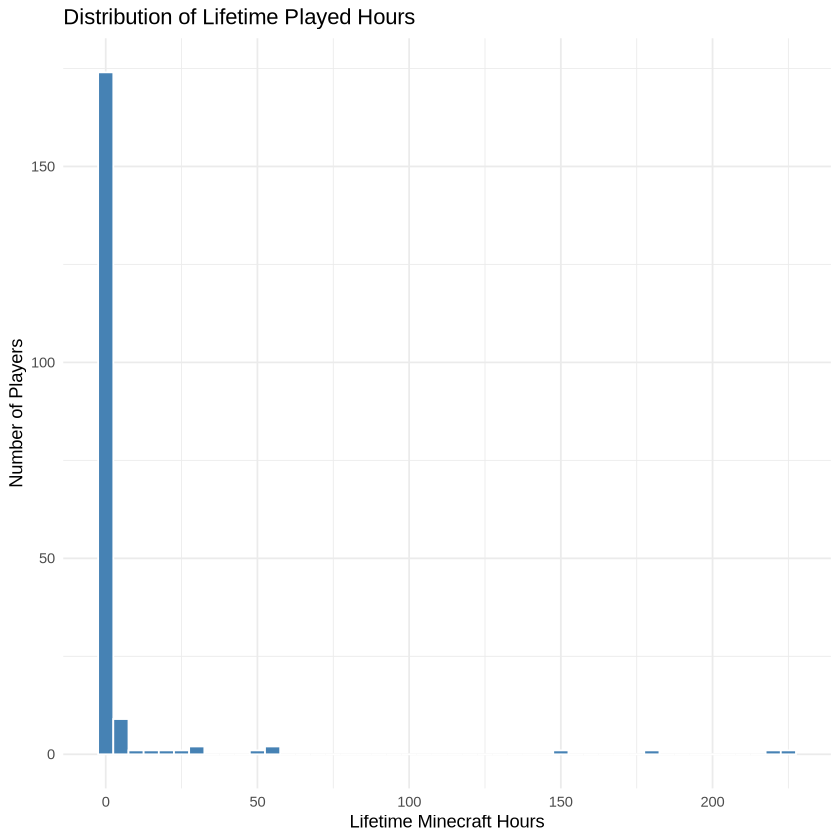

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


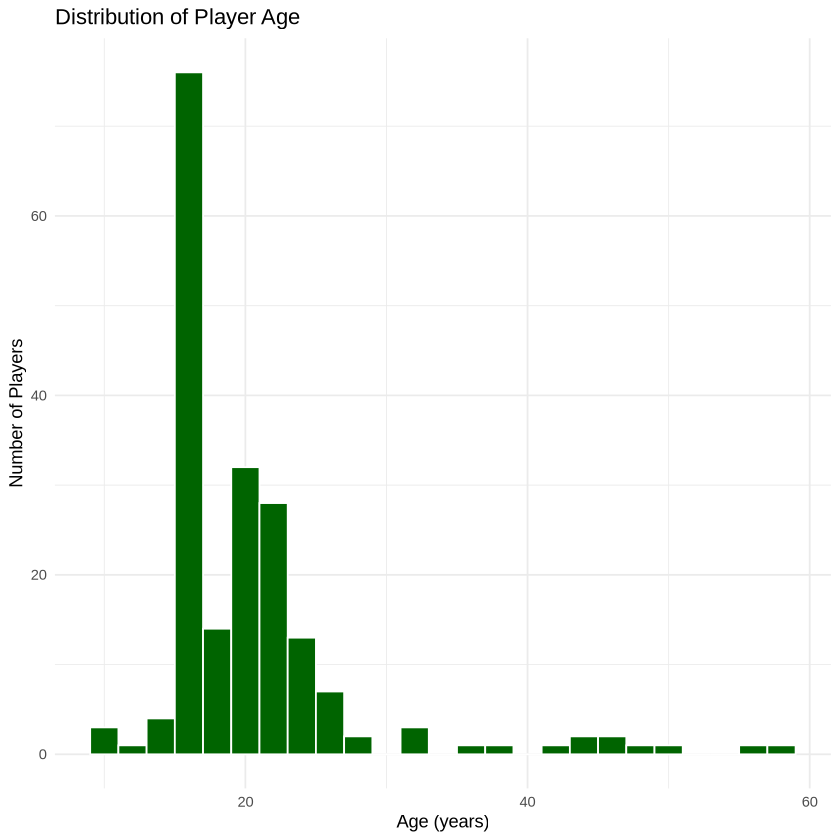

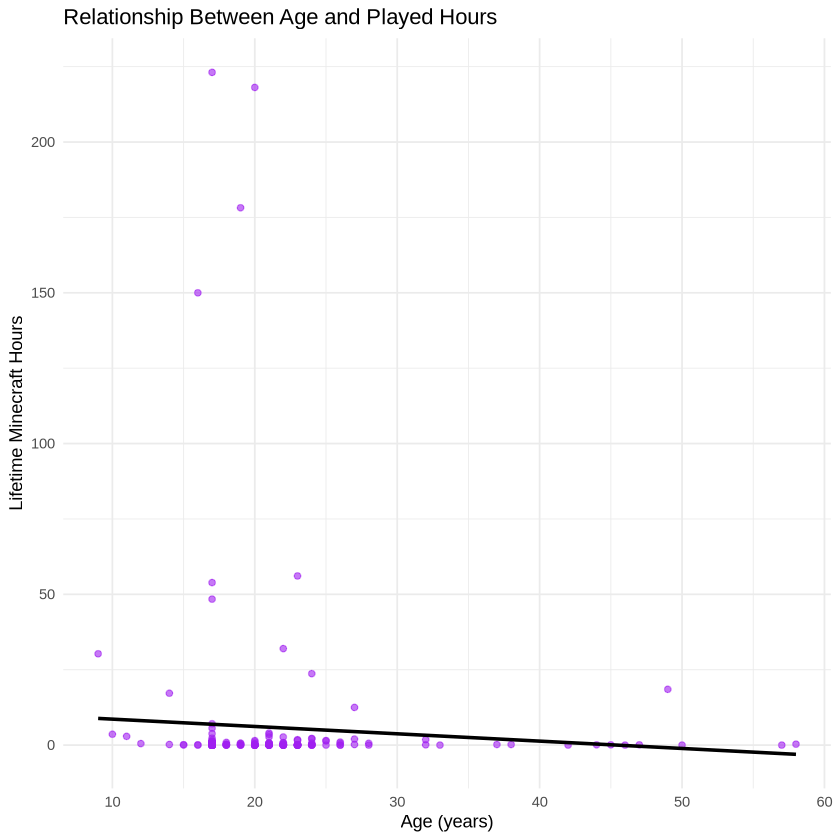

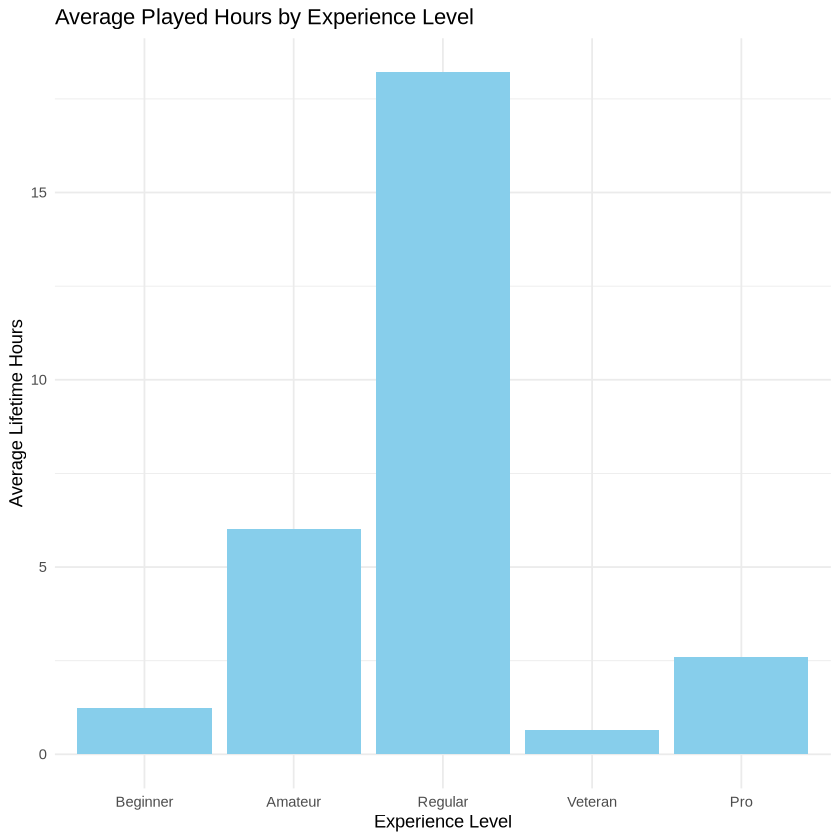

In [4]:
# Mean values for numeric variables
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(everything(), names_to="variable", values_to="mean")

players_means

# 1. Histogram of lifetime played hours
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "white") +
  labs(title = "Distribution of Lifetime Played Hours",
       x = "Lifetime Minecraft Hours",
       y = "Number of Players") +
  theme_minimal()

# 2. Histogram of age
ggplot(players, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "darkgreen", color = "white") +
  labs(title = "Distribution of Player Age",
       x = "Age (years)",
       y = "Number of Players") +
  theme_minimal()

# 3. Scatter plot: Age vs played hours
ggplot(players, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6, color = "purple") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "Relationship Between Age and Played Hours",
       x = "Age (years)",
       y = "Lifetime Minecraft Hours") +
  theme_minimal()

# 4. Bar plot: Average played hours by experience level
players |>
  group_by(experience) |>
  summarise(mean_hours = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = experience, y = mean_hours)) +
  geom_col(fill = "skyblue") +
  labs(title = "Average Played Hours by Experience Level",
       x = "Experience Level",
       y = "Average Lifetime Hours") +
  theme_minimal()


## 3. Exploratory Data Analysis and Visualization

I prepared the players dataset by converting variables to appropriate types and calculating the mean values for each numeric variable. To understand how played_hours relates to age, gender, and experience level, I created four exploratory visualizations that follow best practices and directly support the predictive question.

The histogram of played_hours shows a strong right skew. Most people report low hours, but a few report extremely high numbers. This hints that I might need to transform played_hours later if I use linear modeling.

The second plot is a histogram of Age. Most players are in their late teens or early twenties, with fewer older players. This helps contextualize the scatter plot that follows by showing the range of ages represented in the sample.

The third plot is a scatter plot of Age against played_hours with a fitted linear trend. The points are widely spread, and the trend line appears nearly flat, suggesting that age may not be a strong predictor of lifetime Minecraft hours. There is no clear pattern of older players reporting more or fewer hours compared to younger players.

The final plot is a bar chart showing the average played_hours for each experience level. This visualization shows a clear upward pattern, which is as experience level increases, the average number of reported hours rises as well. This makes sense, since players who identify as more experienced are likely to have played more over time. This plot provides the strongest evidence that experience level may be an important predictor.

These visualizations help me understand the distributions of key variables and how they relate to the response. They also highlight potential challenges, such as skewed data and large variability across individuals. These insights will guide how I process variables and choose appropriate modeling strategies in the next stage of the project.


## 4. Methods and Plan

To answer my question, I’m planning to use linear regression with played_hours as the response. It’s a good fit because the outcome is continuous, and regression lets me see how each predictor changes expected hours. The EDA especially suggested that experience level might be the strongest predictor, and regression will help quantify that.

The method assumes that relationships are roughly linear, observations are independent, the residuals have constant variance, and errors are somewhat normal. The skewed hours distribution might need a transformation to meet these assumptions. Outliers and non-linear patterns are possible weaknesses.

To compare models, I’ll use k-fold cross-validation on the training data so I get a more reliable sense of performance. I’ll use metrics like RMSE to judge which model works best.

Before modeling, I’ll handle missing values, factor-encode predictors correctly, and consider transforming played_hours. I’ll split the data 70% training and 30% testing right away. The test set stays untouched until the very end, and cross-validation happens only inside the training set.
